In [109]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [111]:
# Train data
heart_rate_non_linear_train = pd.read_csv('MonitorStressLevel/TrainData/heart_rate_non_linear_features_train.csv')
time_domain_train = pd.read_csv('MonitorStressLevel/TrainData/time_domain_features_train.csv')
frequency_domain_train = pd.read_csv('MonitorStressLevel/TrainData/frequency_domain_features_train.csv')

# Test data
heart_rate_non_linear_test = pd.read_csv('MonitorStressLevel/TestData/heart_rate_non_linear_features_test.csv')
time_domain_test = pd.read_csv('MonitorStressLevel/TestData/time_domain_features_test.csv')
frequency_domain_test = pd.read_csv('MonitorStressLevel/TestData/frequency_domain_features_test.csv')


In [112]:
print("Train Columns:")
print("heart_rate_non_linear_train:", heart_rate_non_linear_train.columns.tolist())
print("time_domain_train:", time_domain_train.columns.tolist())
print("frequency_domain_train:", frequency_domain_train.columns.tolist())


Train Columns:
heart_rate_non_linear_train: ['uuid', 'SD1', 'SD2', 'sampen', 'higuci', 'datasetId', 'condition']
time_domain_train: ['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR', 'pNN25', 'pNN50', 'KURT', 'SKEW', 'MEAN_REL_RR', 'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR', 'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'uuid']
frequency_domain_train: ['uuid', 'VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF', 'HF_LF']


In [113]:
heart_rate_non_linear_train['datasetId'] = heart_rate_non_linear_train['datasetId'].astype(str)
time_domain_train['uuid'] = time_domain_train['uuid'].astype(str)
frequency_domain_train['uuid'] = frequency_domain_train['uuid'].astype(str)

In [116]:
train_data = pd.merge(heart_rate_non_linear_train, time_domain_train, on='uuid')
train_data = pd.merge(train_data, frequency_domain_train, on='uuid')

In [118]:
train_data.drop(columns=['uuid', 'datasetId'], inplace=True)

In [121]:
condition_mapping = {
    'no stress': 0,
    'interruption': 1,
    'time pressure': 2
}

In [123]:
train_data['condition_numeric'] = train_data['condition'].map(condition_mapping)

# Check the updated DataFrame
print(train_data[['condition', 'condition_numeric']].head())

      condition  condition_numeric
0     no stress                  0
1  interruption                  1
2  interruption                  1
3     no stress                  0
4     no stress                  0


In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Define features (X) and target (y)
X = train_data.drop(columns=['condition', 'condition_numeric', 'SD1'])  # Assuming SD1 is your target
y = train_data['SD1']  # Replace 'SD1' with the actual target column name if different

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape the data for LSTM input (samples, timesteps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Check shapes and types
print(X_train_reshaped.shape)
print(y_train.shape)
print(X_val_reshaped.shape)
print(y_val.shape)

(295431, 1, 33)
(295431,)
(73858, 1, 33)
(73858,)


In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Build the RNN model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
    Dropout(0.2),
    Dense(1)  # Final layer for regression (single output for heart rate)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# View model summary
model.summary()

C:\Users\chali\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        16,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,851 (65.82 KB)

 Trainable params: 16,851 (65.82 KB)

 Non-trainable params: 0 (0.00 B)

In [129]:
# Train the model with smaller batch size
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=16, validation_data=(X_val_reshaped, y_val), verbose=1)

Epoch 1/100
18465/18465 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 6.8101 - val_loss: 0.0129
Epoch 2/100
18465/18465 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 0.2336 - val_loss: 0.0059
Epoch 3/100
18465/18465 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 0.1134 - val_loss: 0.0063
Epoch 4/100
18465/18465 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 0.1068 - val_loss: 0.0168
Epoch 5/100
18465/18465 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.1057 - val_loss: 0.0079
Epoch 6/100
18465/18465 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 0.1038 - val_loss: 0.0051
Epoch 7/100
18465/18465 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.1051 - val_loss: 0.0056
Epoch 8/100
18465/18465 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 0.1047 - val_loss: 0.0024
Epoch 9/100
18465/18465 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 0.1054 - val_loss: 0.0042
Epoch 10/100
18465/18465 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 0.1038 - val_loss: 0.0046
Epoch 11/100
18465/18465 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - loss: 0.1039 - val

In [130]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictions on validation data
y_pred = model.predict(X_val_reshaped)

# Calculate metrics
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Print results
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

2309/2309 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Mean Squared Error: 0.005787170152793999
Root Mean Squared Error: 0.07607345235227594
R² Score: 0.9993226358293013


In [131]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Convert 'uuid' to the same type
heart_rate_non_linear_test['uuid'] = heart_rate_non_linear_test['uuid'].astype(str)
time_domain_test['uuid'] = time_domain_test['uuid'].astype(str)
frequency_domain_test['uuid'] = frequency_domain_test['uuid'].astype(str)

# Merge the test datasets on 'uuid'
test_data = pd.merge(heart_rate_non_linear_test, time_domain_test, on='uuid')
test_data = pd.merge(test_data, frequency_domain_test, on='uuid')

# Drop unnecessary columns like 'uuid', 'datasetId', and 'condition'
test_data.drop(columns=['uuid', 'datasetId', 'condition'], inplace=True)

# Drop the target variable 'SD1' from test data since it's not a feature
X_test = test_data.drop(columns=['SD1'], errors='ignore')  # Avoid error if 'SD1' is already missing

# Get the feature names used during training (assuming 'X' from training is available)
train_features = list(X.columns)

# Ensure only the features used during training are present in the test data
# If a feature from training is missing in the test data, fill it with zeros or an appropriate value
X_test = X_test.reindex(columns=train_features, fill_value=0)  # Fill missing columns with 0

# Use the same scaler that was fitted on the training data to scale the test data
X_test_scaled = scaler.transform(X_test)

# Extract the actual heart rate values from the test data (replace 'SD1' with your actual target column)
y_test_actual = heart_rate_non_linear_test['SD1']  # Replace 'SD1' with actual target column name if different

# Reshape the test data for LSTM input (samples, timesteps, features)
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Make predictions on the test data
y_test_pred = model.predict(X_test_reshaped)

# Convert predictions and actual values to a DataFrame for easy comparison
predictions_df = pd.DataFrame({
    'Actual Heart Rate': y_test_actual,  # Actual heart rate values
    'Predicted Heart Rate': y_test_pred.flatten()  # Predicted heart rate values (flattened for a 1D array)
})

# Print the predicted heart rate values and actual heart rate values
print(predictions_df)

# Optionally, save to CSV for further analysis
predictions_df.to_csv('MonitorStressLevel/predictions.csv', index=False)


1283/1283 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step
       Actual Heart Rate  Predicted Heart Rate
0               8.347898              8.586555
1              14.542096             14.142150
2               9.799336              9.500708
3              11.639185             11.007239
4               7.266567              7.637882
...                  ...                   ...
41028           7.560479              7.973879
41029           6.150725              6.537332
41030          15.388795             15.050087
41031           5.327684              5.643811
41032           9.556202              9.320479

[41033 rows x 2 columns]


In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

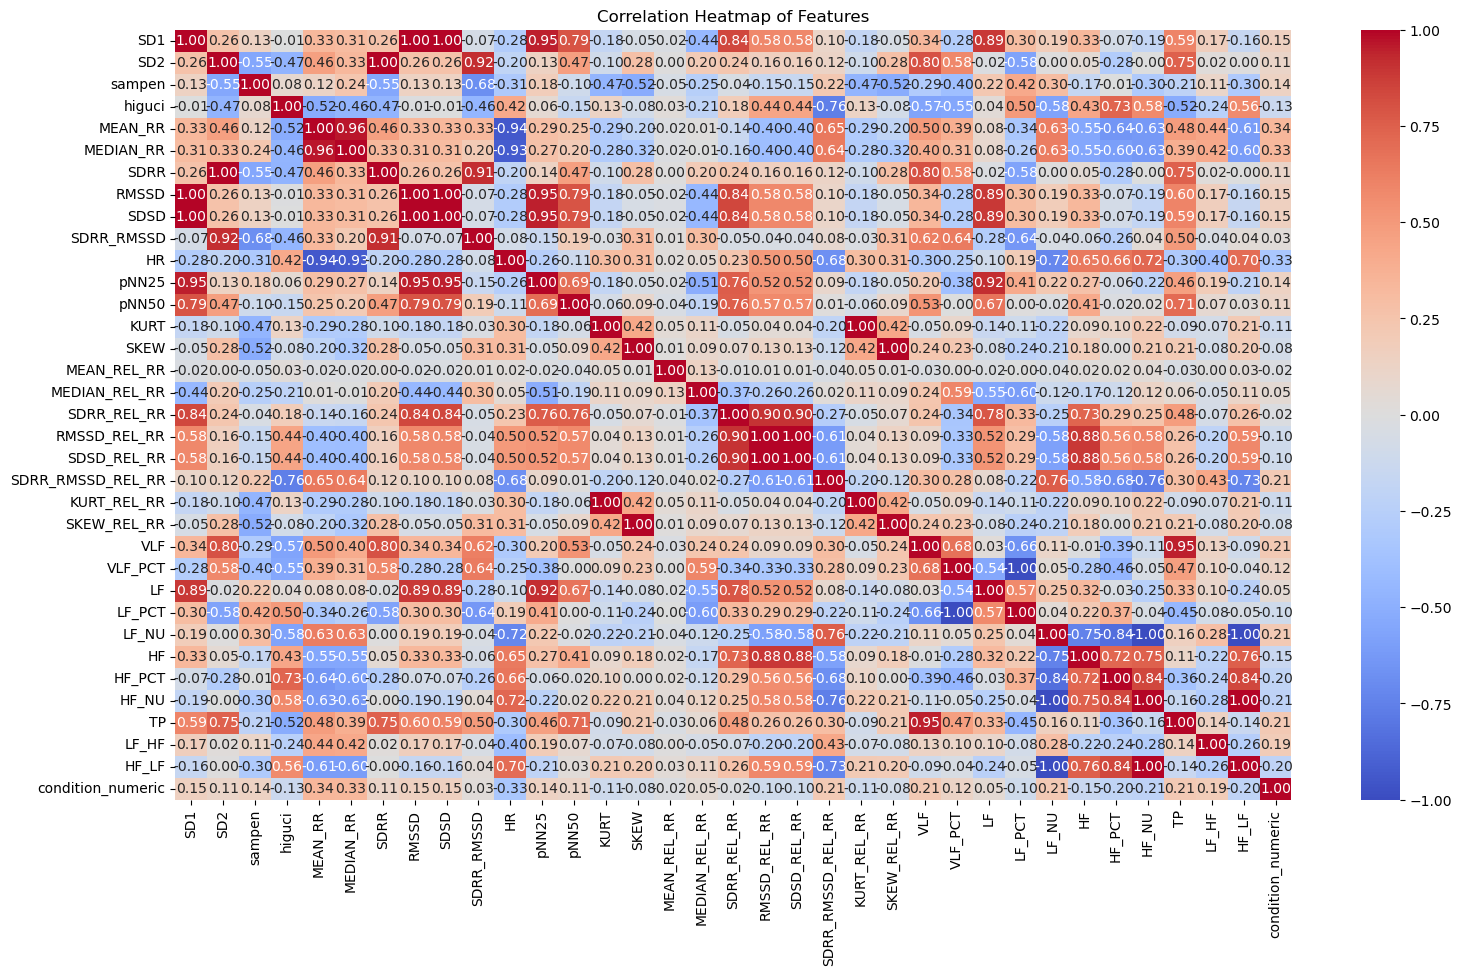

In [133]:
# Drop non-numeric columns before generating the correlation matrix
numeric_data = train_data.drop(columns=['condition'])

# Correlation Heatmap
plt.figure(figsize=(18, 10))
correlation_matrix = numeric_data.corr()  # Only use numeric columns
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

C:\Users\chali\AppData\Local\Temp\ipykernel_5156\577372797.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='MEAN_RR', data=train_data, palette='Set2')


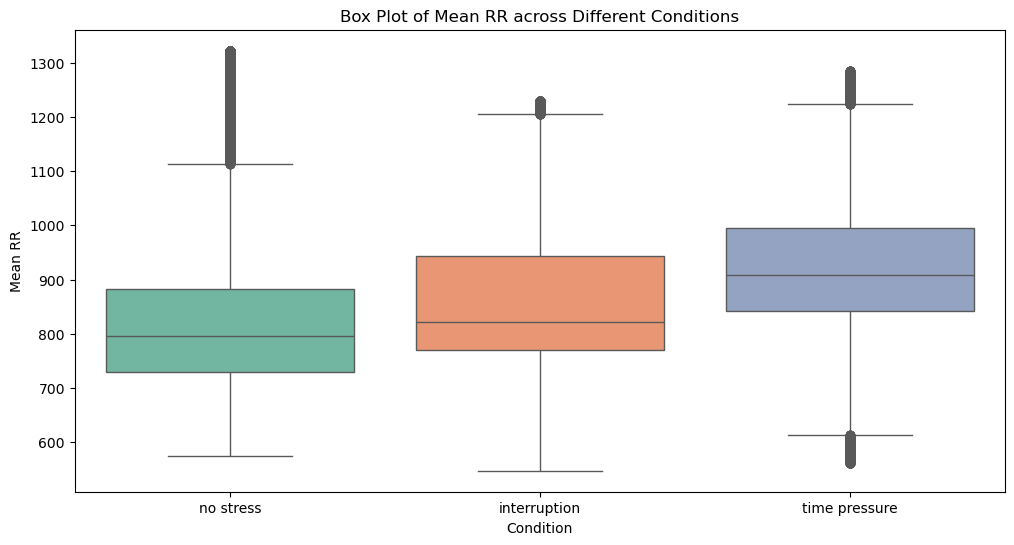

In [134]:
# 3. Box Plot - Visualize the distribution of features across different conditions
plt.figure(figsize=(12, 6))
sns.boxplot(x='condition', y='MEAN_RR', data=train_data, palette='Set2')
plt.title('Box Plot of Mean RR across Different Conditions')
plt.xlabel('Condition')
plt.ylabel('Mean RR')
plt.show()

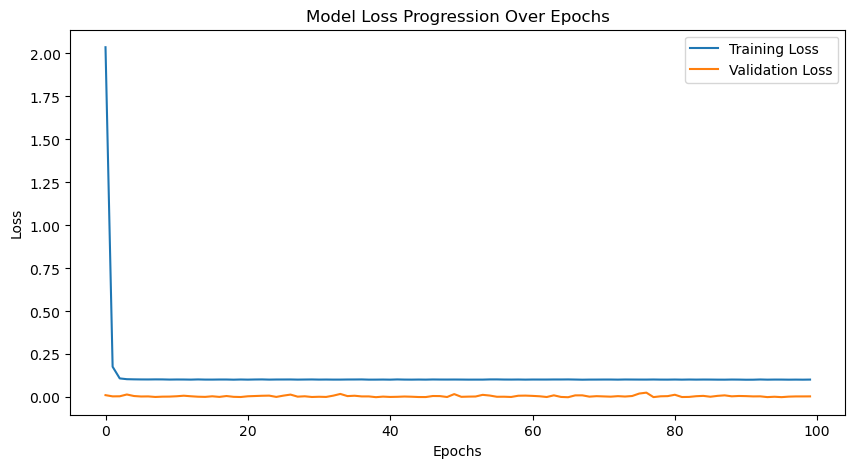

In [135]:
# 4. Line Plot to show model loss progression over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()